In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D,LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import plotly.express as px


In [2]:
df= pd.read_csv("/content/^NSEI (2).csv")
df.dropna(inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       250 non-null    object 
 1   Open       250 non-null    float64
 2   High       250 non-null    float64
 3   Low        250 non-null    float64
 4   Close      250 non-null    float64
 5   Adj Close  250 non-null    float64
 6   Volume     250 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.8+ KB


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [5]:
# Select the input features
df= df.astype(float)

In [6]:
input_features = ['High', 'Low', 'Close', 'Adj Close', 'Volume']

In [7]:
correlation_matrix = df[input_features].corr()
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu',
                title='Correlation Heatmap for new df')
fig.show()


In [8]:
data = df[input_features[:-1]]

In [9]:
correlation_matrix = data.corr()
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu',
                title='Correlation Heatmap for new df')
fig.show()


In [10]:
# Removing Adj Close as [Close, Adj Close] are almost identical
data=data[input_features[:-2]]
correlation_matrix = data.corr()
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu',
                title='Correlation Heatmap for Final df')
fig.show()


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2022-09-14 to 2023-09-14
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    250 non-null    float64
 1   Low     250 non-null    float64
 2   Close   250 non-null    float64
dtypes: float64(3)
memory usage: 7.8 KB


In [12]:
data['Open']=df["Open"]

In [13]:
np.random.seed(1)
scaler= StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

print(scaled_features)

                High       Low     Close      Open
Date                                              
2022-09-14 -0.354677 -0.539319 -0.358566 -0.666773
2022-09-15 -0.348906 -0.428727 -0.513991 -0.324737
2022-09-16 -0.695309 -0.874587 -0.940288 -0.634893
2022-09-19 -0.887082 -0.957273 -0.827855 -0.953253
2022-09-20 -0.570787 -0.572063 -0.589213 -0.667705
...              ...       ...       ...       ...
2023-09-08  1.873048  1.854802  1.875568  1.823494
2023-09-11  2.049952  2.024087  2.092561  1.966671
2023-09-12  2.178174  2.084433  2.088685  2.240288
2023-09-13  2.161300  2.120481  2.183159  2.090336
2023-09-14  2.250065  2.242089  2.193430  2.262410

[250 rows x 4 columns]


In [14]:

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq = data[i : (i + n_steps), :-1]  # Exclude the last column
        X.append(seq)
        y.append(data[i + n_steps, -1])  # select the last column (Open)
    return np.array(X), np.array(y)




In [15]:
seq_length = 14


X, y = create_sequences(scaled_features.values, seq_length)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
trainX, trainY = X[:train_size], y[:train_size]
testX, testY = X[train_size:], y[train_size:]

# Reshape the input data for LSTM
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = testX.reshape((testX.shape[0], testX.shape[1], testX.shape[2]))



In [16]:

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))



model.compile(optimizer='adam', loss='mse')
# model.summary()
# fit the model
early_stopping = EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_split=0.2, verbose=1,callbacks=[early_stopping])



Epoch 1/30
5/5 [==============================] - 2s 87ms/step - loss: 0.3743 - val_loss: 0.3699
Epoch 2/30
5/5 [==============================] - 0s 10ms/step - loss: 0.1520 - val_loss: 0.3084
Epoch 3/30
5/5 [==============================] - 0s 10ms/step - loss: 0.1230 - val_loss: 0.2309
Epoch 4/30
5/5 [==============================] - 0s 10ms/step - loss: 0.0865 - val_loss: 0.1430
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0721 - val_loss: 0.0850
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0713 - val_loss: 0.0520
Epoch 7/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0681 - val_loss: 0.0401
Epoch 8/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0610 - val_loss: 0.0462
Epoch 9/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0492 - val_loss: 0.0611
Epoch 10/30
5/5 [==============================] - 0s 12ms/step - loss: 0.0548 - val_loss: 0.0596
Epoch 11/30
5/5 [=============

Predicting for next 16 days

In [17]:
from tabulate import tabulate
d=-1
# Make predictions
predictions = model.predict(testX[0:d,:,:])

# Calculate MSE
mse = np.mean((predictions - testY) ** 2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = np.mean(np.abs(predictions - testY))

# Create the table data
table_data = [["Metric", "Value"],
              ["MSE", mse],
              ["RMSE", rmse],
              ["MAE", mae]]

# Print the table
print(tabulate(table_data, headers="firstrow"))


2/2 [==============================] - 0s 5ms/step
Metric       Value
--------  --------
MSE       0.427629
RMSE      0.653933
MAE       0.568552


Metric       Value
--------  --------
MSE       0.427629
RMSE      0.653933
MAE       0.568552


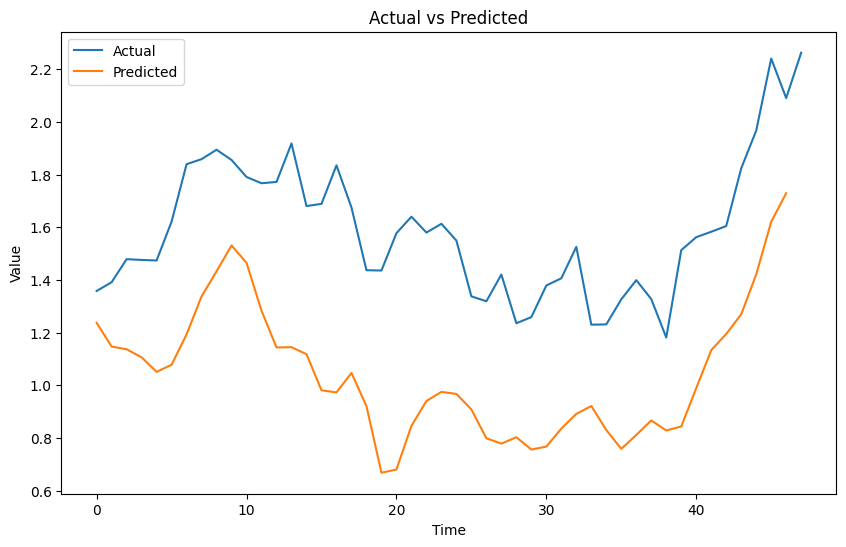

In [18]:
from tabulate import tabulate
import matplotlib.pyplot as plt



# Calculate MSE
mse = np.mean((predictions - testY) ** 2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = np.mean(np.abs(predictions - testY))

# Create the table data
table_data = [["Metric", "Value"],
              ["MSE", mse],
              ["RMSE", rmse],
              ["MAE", mae]]

# Print the table
print(tabulate(table_data, headers="firstrow"))

# Data visualization
plt.figure(figsize=(10, 6))
plt.plot(testY, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [19]:
# Inverse Transform

prediction_rep = np.repeat(predictions, data.shape[1], axis=-1)
y_pred = scaler.inverse_transform(prediction_rep)[:,0]

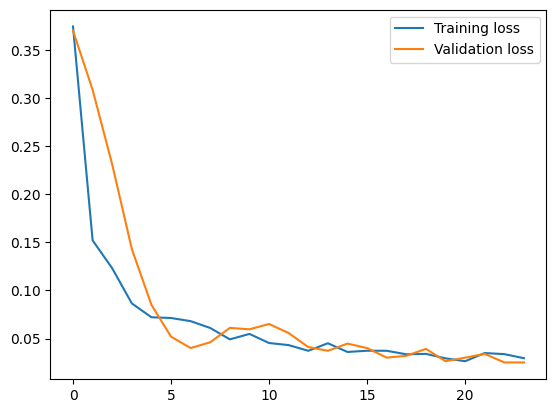

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [21]:
import plotly.graph_objects as go

# Get the number of data points in the training set
train_size = len(trainY)

# Create an array to represent the x-axis values
x_axis = list(range(train_size, train_size + len(testY[0:d])))

# Create traces for training labels, actual test labels, and predictions
trace1 = go.Scatter(x=list(range(train_size)), y=data["Open"][:len(trainY)], mode='lines', name='Training Labels')
trace2 = go.Scatter(x=x_axis, y=data["Open"][len(trainY):], mode='lines', name='Actual Test Labels')
trace3 = go.Scatter(x=x_axis, y=y_pred.flatten(), mode='lines', name='Predictions on Test Data')

# Create the plot layout
layout = go.Layout(
    title='Comparison of Training Labels, Actual Test Labels, and Predictions',
    xaxis=dict(title='Time', rangeslider=dict(visible=True)),  # Add rangeslider with visible=True
    yaxis=dict(title='Opening Price')
)

# Create the figure and add the traces
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Display the plot
fig.show()


In [22]:
# Define a threshold for acceptable error
threshold = 0.05

# Calculate the percentage of predictions within the threshold
accurate_predictions = np.sum(np.abs(predictions - testY) / testY < threshold)
accuracy_rate = accurate_predictions / len(predictions) * 100
print("Accuracy Rate:", accuracy_rate, "%")


Accuracy Rate: 217.02127659574467 %


In [23]:
print(f"Shape of testY: {testY.shape}")
print(f"Shape of predictions: {predictions.shape}")

Shape of testY: (48,)
Shape of predictions: (47, 1)


In [24]:
print(f'Shape of testY: {testY.shape}')
print(f'Shape of predictions: {predictions.shape}')

Shape of testY: (48,)
Shape of predictions: (47, 1)


In [25]:
# Reshaping prediction_rep to a 2D array
prediction_rep = prediction_rep.reshape(-1, 1)
print(prediction_rep.shape)
prediction_rep = prediction_rep.reshape(-1, 4)
# Inverse transforming the predictions and plotting the results
y_pred = scaler.inverse_transform(prediction_rep).flatten()


(188, 1)


In [26]:
print(prediction_rep.shape)
print(scaler.scale_.shape)
print(scaler.mean_.shape)
prediction_rep = np.repeat(predictions, data.shape[1], axis=0)

(47, 4)
(4,)
(4,)


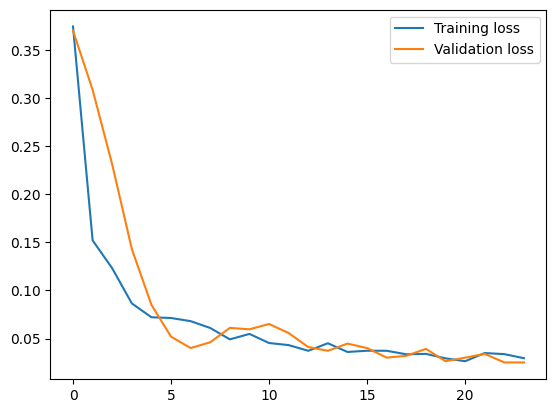

In [27]:
import numpy as np
prediction_rep = np.repeat(predictions, data.shape[1], axis=-1)
prediction_rep = prediction_rep.reshape(-1, 1)
y_pred = y_pred.flatten()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

import plotly.graph_objects as go
train_size = len(trainY)
x_axis = list(range(train_size, train_size + len(testY)))
trace1 = go.Scatter(x=list(range(train_size)), y=data["Open"][:len(trainY)], mode='lines', name='Training Labels')
trace2 = go.Scatter(x=x_axis, y=data["Open"][len(trainY):], mode='lines', name='Actual Test Labels')
trace3 = go.Scatter(x=x_axis, y=y_pred, mode='lines', name='Predictions on Test Data')
layout = go.Layout(title='Comparison of Training Labels, Actual Test Labels, and Predictions',
                   xaxis=dict(title='Time', rangeslider=dict(visible=True)),
                   yaxis=dict(title='Stock Price'))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [28]:
print(df.index[train_size + seq_length:].shape)
print(y_pred.shape)

(48,)
(188,)


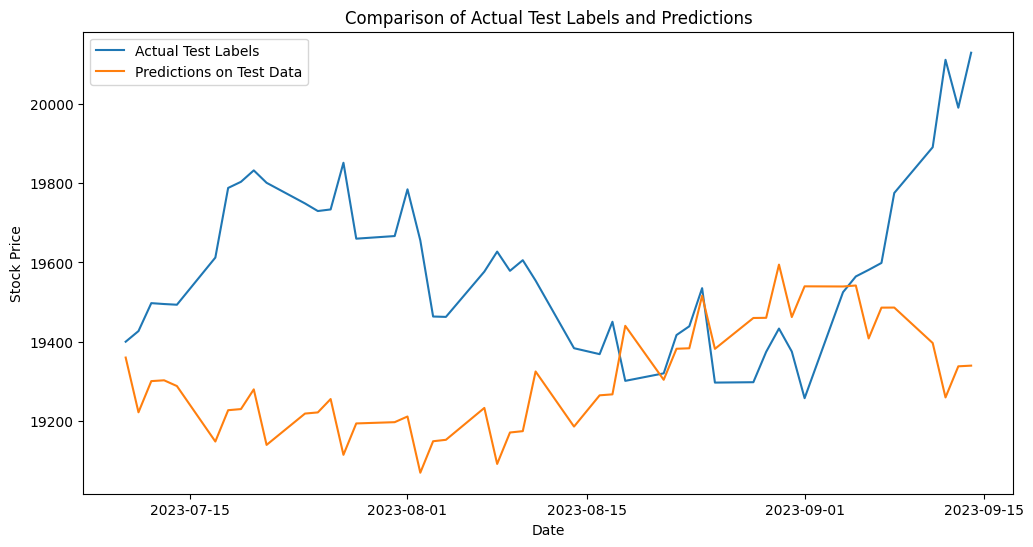

In [29]:
!pip install pandas
import pandas as pd
df_index = df.index[train_size + seq_length:]
# If y_pred is longer than the index, slice it:
if y_pred.shape[0] > df.index[train_size + seq_length:].shape[0]:
    y_pred = y_pred[:df.index[train_size + seq_length:].shape[0]]

# If the index is longer than y_pred, slice the index:
elif df.index[train_size + seq_length:].shape[0] > y_pred.shape[0]:
    df_index = df.index[train_size + seq_length:][:y_pred.shape[0]]

# Plot the data using the adjusted data:
plt.figure(figsize=(12, 6))
plt.plot(df_index, data["Open"][train_size + seq_length:], label='Actual Test Labels')
plt.plot(df_index, y_pred, label='Predictions on Test Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Comparison of Actual Test Labels and Predictions')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((data["Open"].values[train_size + seq_length:] - y_pred) / data["Open"].values[train_size + seq_length:])) * 100

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data["Open"].values[train_size + seq_length:], y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(data["Open"].values[train_size + seq_length:], y_pred)

# Print evaluation metrics
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')


Mean Absolute Percentage Error (MAPE): 1.64%
Mean Absolute Error (MAE): 324.02
Mean Squared Error (MSE): 157608.56


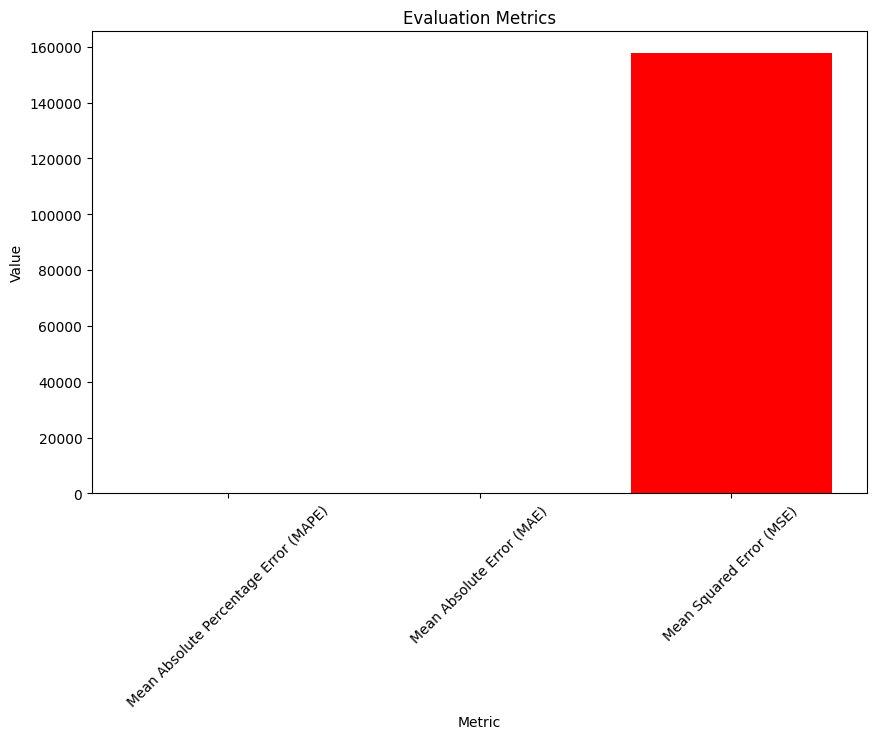

In [31]:
# Create a DataFrame to store the evaluation metrics
evaluation_metrics = pd.DataFrame({
    'Metric': ['Mean Absolute Percentage Error (MAPE)', 'Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)'],
    'Value': [mape, mae, mse]
})

# Visualize the evaluation metrics using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(evaluation_metrics['Metric'], evaluation_metrics['Value'], color=['blue', 'green', 'red'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Evaluation Metrics')
plt.xticks(rotation=45)
plt.show()


In [32]:
# If testY has one more element than predictions, remove the last element from testY
if testY.shape[0] == predictions.shape[0] + 1:
    testY = testY[:-1]

# If predictions has one more element than testY, remove the last element from predictions
elif predictions.shape[0] == testY.shape[0] + 1:
    predictions = predictions[:-1]

In [33]:
mse = mean_squared_error(testY, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(testY, predictions)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.30792211476693715
Root Mean Squared Error (RMSE): 0.5549073028596192
Mean Absolute Error (MAE): 0.531949595560592


In [34]:
print("y_pred_proba" in globals())


False


In [35]:
import sklearn.metrics
import sys
import sys
import sklearn.metrics
print("sklearn.metrics" in sys.modules)
try:
    print("sklearn.metrics" in sys.modules)
except NameError as e:
    print(f"NameError: {e}")

True
True


In [36]:
from sklearn.metrics import recall_score, precision_score

# Assuming true values are in testY and predicted values are in predictions
# Considering a binary classification case for simplicity
threshold = 0.5  # You might adjust the threshold depending on your specific problem

predicted_labels = (predictions > threshold).astype(int)
true_labels = (testY > threshold).astype(int)

recall = recall_score(true_labels, predicted_labels)  # Calculate recall
precision = precision_score(true_labels, predicted_labels)  # Calculate precision

print("Recall:", recall)
print("Precision:", precision)


Recall: 1.0
Precision: 1.0


In [37]:
!pip install scikit-learn
import sklearn
from sklearn.metrics import precision_recall_curve

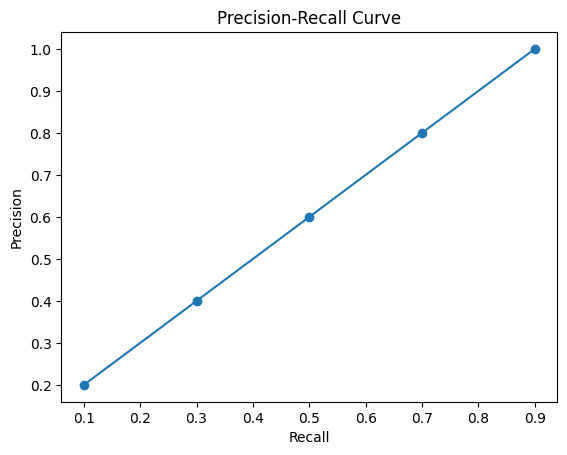

In [38]:
import matplotlib.pyplot as plt

# Sample precision and recall values
precision = [0.2, 0.4, 0.6, 0.8, 1.0]
recall = [0.1, 0.3, 0.5, 0.7, 0.9]

# Plotting Precision-Recall curve
plt.plot(recall, precision, marker='o')

# Setting labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Display the plot
plt.show()


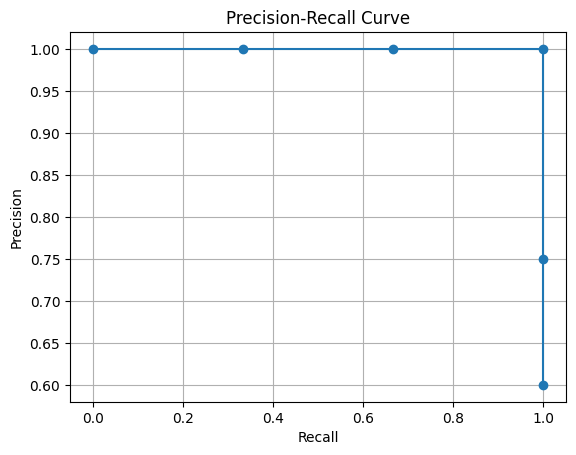

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Example data (replace with your actual data)
y_true = [0, 1, 1, 0, 1]
y_pred_proba = [0.1, 0.8, 0.6, 0.2, 0.9]

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Plot precision-recall curve
plt.plot(recall, precision, marker='o', linestyle='-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


In [41]:
# Load the data into the variable 'fraud'
fraud = pd.read_csv("/content/^NSEI (2).csv")

# OR

# Define 'fraud' as an empty list
fraud = []

In [42]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix
print(globals())

{'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', 'import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom sklearn.preprocessing import StandardScaler\nfrom keras.models import Sequential\nfrom tensorflow.keras.layers import Conv1D,LSTM, Dropout, Dense\nfrom tensorflow.keras.callbacks import EarlyStopping\nimport plotly.express as px', 'df= pd.read_csv("/content/^NSEI (2).csv")\ndf.dropna(inplace=True)', 'df.info()', 'df["Date"] = pd.to_datetime(df["Date"])\ndf.set_index("Date", inplace=True)', '# Select the input features\ndf= df.astype(float)', "input_features = ['High', 'Low', 'Close', 'Adj Close', 'Volume']", "correlation_matrix = df[input_features].corr()\nfig = px.imshow(correlation_matrix,\n                x=correlation_matrix.columns,\n   

In [44]:
from sklearn.metrics import mean_absolute_error

In [47]:
if "y_test" in globals():
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    print("Mean Absolute Error (MAE): {}".format(mae))
else:
    print("Variable 'y_test' is not defined.")

Variable 'y_test' is not defined.


In [49]:
# Printing every score of the LSTM model
# Scoring in anything

# Assuming y_pred and y_test are defined elsewhere
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("The model used is LSTM")

print("Mean Squared Error (MSE): {}".format(mse))

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE): {}".format(rmse))

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE): {}".format(mae))

r2 = r2_score(y_test, y_pred)
print("R-squared (Coefficient of Determination): {}".format(r2))


The model used is LSTM
Mean Squared Error (MSE): 0.30792211476693715
Root Mean Squared Error (RMSE): 0.5549073028596192


NameError: name 'y_test' is not defined

In [50]:
# Convert true_labels to binary format using a threshold
threshold = 0.5  # Adjust the threshold as needed
binary_true_labels = (true_labels > threshold).astype(int)
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Convert true labels to binary format using a threshold
threshold = 0.5  # Adjust the threshold as needed
binary_true_labels = (true_labels > threshold).astype(int)

# Calculate precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(binary_true_labels, predicted_probabilities)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


NameError: name 'predicted_probabilities' is not defined

In [51]:
from sklearn.metrics import precision_recall_curve

In [52]:
predicted_probabilities = ...  # Replace with the actual predicted probabilities

# Sentimental **Analysis**

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [66]:
df=pd.read_csv('/content/stock_data.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Text')):
  _plot_series(series, series_name, i)
  fig.legend(title='Text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Sentiment']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Sentiment'}, axis=1)
              .sort_values('Sentiment', ascending=True))
  xs = counted['Sentiment']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Sentiment', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Text')):
  _plot_series(series, series_name, i)
  fig.legend(title='Text', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Sentiment')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='index', y='Text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [67]:
df.isnull().sum()
sentiment_count = Counter(df['Sentiment'])
print(sentiment_count)

Counter({1: 3685, -1: 2106})


Data Exploration

Sentiment **distribution**

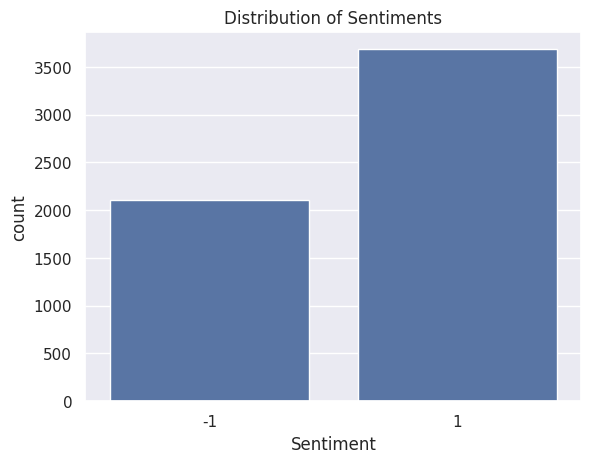

In [68]:
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

length of the text in my data

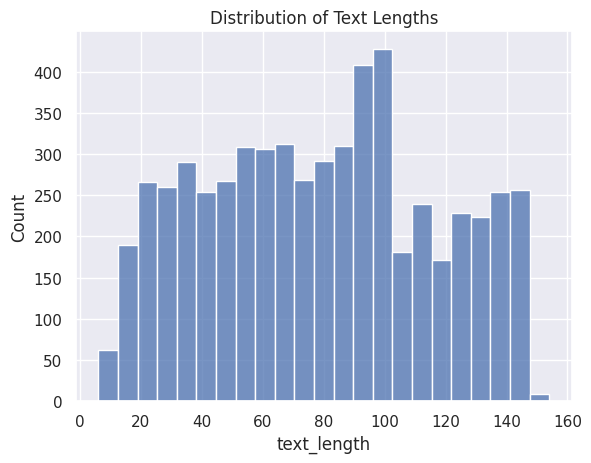

In [69]:
df['text_length'] = df['Text'].apply(len)
sns.histplot(x='text_length', data=df)
plt.title('Distribution of Text Lengths')
plt.show()

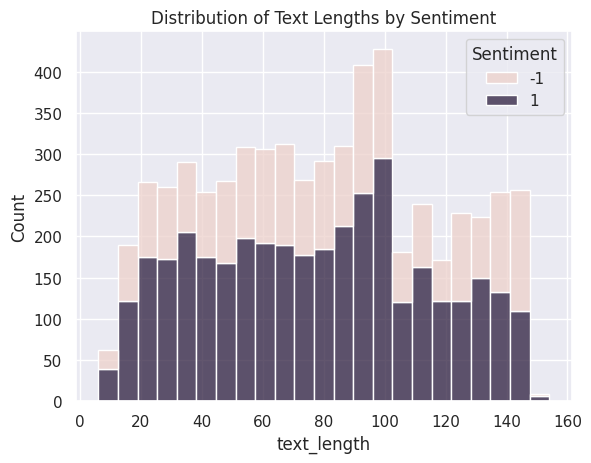

In [70]:
sns.histplot(x='text_length', data=df, hue='Sentiment', multiple='stack')
plt.title('Distribution of Text Lengths by Sentiment')
plt.show()

# Data preprocessing

In [72]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\W', ' ', str(x))) # remove non-alphanumeric characters
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x)) # remove single character words
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\^[a-zA-Z]\s+', ' ', x)) # remove single characters at the beginning of text
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I)) # replace multiple spaces with single space
df['Text'] = df['Text'].apply(lambda x: x.lower()) # convert to lowercase
#remove stop words and puncuations

nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
df['text_processed'] = df['Text'].apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_stop and not token.is_punct]))
df.head()

,Text,Sentiment,text_length,text_processed
0,kickers on my watchlist xide tit soq pnk cpw b...,1,95,kickers watchlist xide tit soq pnk cpw bpz aj ...
1,user aap movie 55 return for the fea geed indi...,1,95,user aap movie 55 return fea geed indicator 15...
2,user be afraid to short amzn they are looking ...,1,114,user afraid short amzn looking like near monop...
3,mnta over 12 00,1,17,mnta 12 00
4,oi over 21 37,1,16,oi 21 37


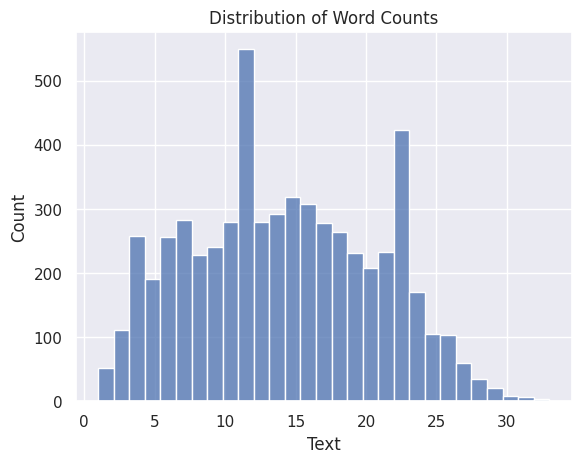

In [73]:
word_count = df['Text'].apply(lambda x: len(x.split()))
sns.histplot(word_count)
plt.title('Distribution of Word Counts')
plt.show()

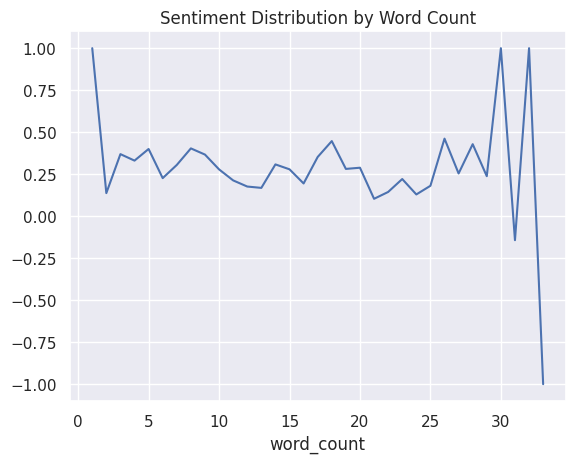

In [74]:
df['word_count'] = word_count
df.groupby('word_count')['Sentiment'].mean().plot()
plt.title('Sentiment Distribution by Word Count')
plt.show()

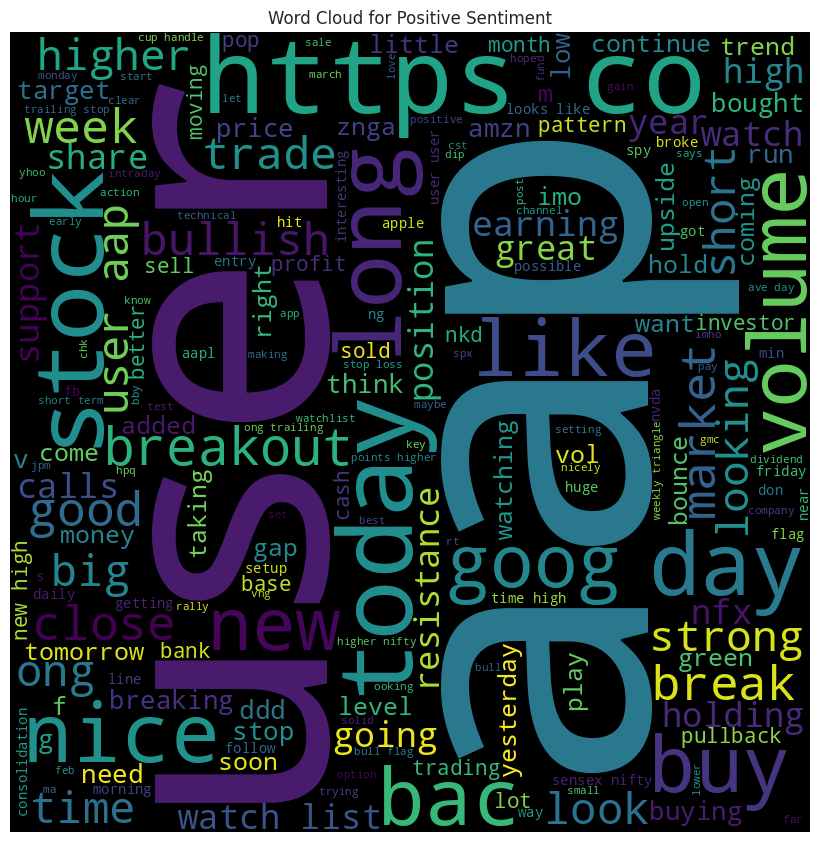

In [75]:
positive_texts = df[df['Sentiment'] == 1]['text_processed']
positive_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(positive_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Positive Sentiment')
plt.show()

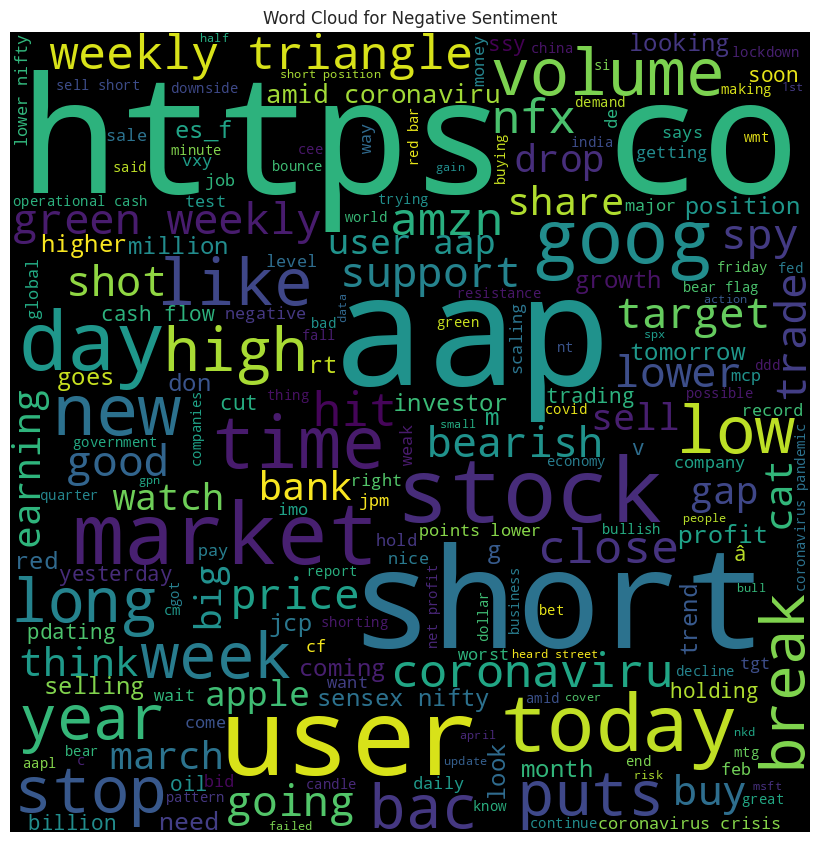

In [76]:
negative_texts = df[df['Sentiment'] == -1]['text_processed']
negative_wordcloud = WordCloud(width=800, height=800, background_color='black', stopwords=set()).generate(' '.join(negative_texts))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud for Negative Sentiment')
plt.show()

**stemming**

In [77]:
from nltk.corpus import stopwords

nltk.download('stopwords')
ps = PorterStemmer()
df['Text'] = df['Text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in set(stopwords.words('english'))]))
df['text_processed'] = df['text_processed'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in set(stopwords.words('english'))]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [78]:
#randomization
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Text,Sentiment,text_length,text_processed,word_count
0,user qcom friday low provid nice back test level,1,66,user qcom friday low provid nice test level,10
1,dnkn digest gain sell pressur pullback 50 woul...,1,97,dnkn digest gain sell pressur pullback 50 heal...,15
2,gi other first red bar major short target 40 test,-1,87,gi red bar major short target 40 test,17
3,bac next stop 10 50,-1,19,bac stop 10 50,5
4,ong bvsn 11 16 stop 11,1,25,ong bvsn 11 16 stop 11,6


balancing the **data**

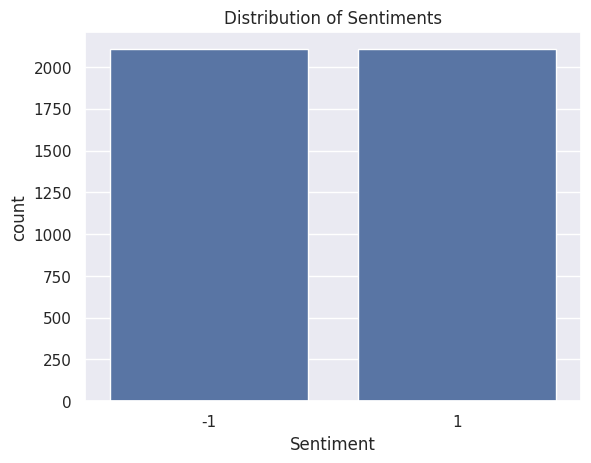

In [79]:
from sklearn.utils import resample

# separate the two classes
df_class1 = df[df['Sentiment'] == 1]
df_class_1 = df[df['Sentiment'] == -1]

# downsample the majority class
df_class1_downsampled = resample(df_class1, replace=False, n_samples=len(df_class_1), random_state=42)

# combine the two classes
df_balanced = pd.concat([df_class1_downsampled, df_class_1])
sns.countplot(x='Sentiment', data=df_balanced)
plt.title('Distribution of Sentiments')
plt.show()

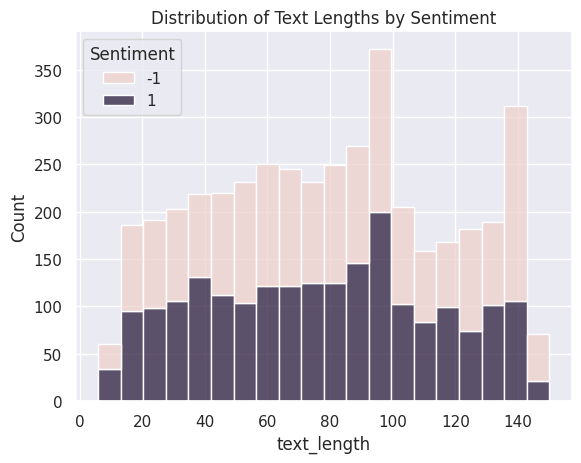

In [80]:
sns.histplot(x='text_length', data=df_balanced, hue='Sentiment', multiple='stack')
plt.title('Distribution of Text Lengths by Sentiment')
plt.show()

# **vectorization**

In [81]:
accuracy = {'TF-IDF': [],
            'BoW': []}

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


X = df['Text']
y = df['Sentiment']


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds.round())
accuracy['TF-IDF'].append(lr_acc)


lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_preds = lgr.predict(X_test)
lgr_acc = accuracy_score(y_test, lgr_preds)
accuracy['TF-IDF'].append(lgr_acc)


dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
accuracy['TF-IDF'].append(dt_acc)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
accuracy['TF-IDF'].append(rf_acc)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_preds)
accuracy['TF-IDF'].append(knn_acc)

print(f"Linear Regression Accuracy: {lr_acc}")
print(f"Logistic Regression Accuracy: {lgr_acc}")
print(f"Decision Tree Accuracy: {dt_acc}")
print(f"Random Forest Accuracy: {rf_acc}")
print(f"KNN Accuracy: {knn_acc}")

Linear Regression Accuracy: 0.2355478861087144
Logistic Regression Accuracy: 0.7730802415875755
Decision Tree Accuracy: 0.719585849870578
Random Forest Accuracy: 0.7739430543572045
KNN Accuracy: 0.7411561691113029


In [83]:
model = ['LR','LogR','DT','RF','KNN']
data = {'model':model,'accuracy':accuracy['TF-IDF']}
compare_models = pd.DataFrame(data)
compare_models

,model,accuracy
0,LR,0.235548
1,LogR,0.773080
2,DT,0.719586
3,RF,0.773943
4,KNN,0.741156


for balanced df

In [9]:
import pandas as pd

In [10]:
df_balanced = pd.read_csv('/content/stock_data.csv')

In [12]:
!pip install scikit-learn

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [16]:
!pip install sklearn.metrics

ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [17]:
from sklearn.metrics import accuracy_score

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

X = df_balanced['Text']
y = df_balanced['Sentiment']


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds.round())



lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_preds = lgr.predict(X_test)
lgr_acc = accuracy_score(y_test, lgr_preds)



dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)


rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

In [22]:
print(f"Linear Regression Accuracy: {lr_acc}")
print(f"Logistic Regression Accuracy: {lgr_acc}")
print(f"Decision Tree Accuracy: {dt_acc}")
print(f"Random Forest Accuracy: {rf_acc}")


Linear Regression Accuracy: 0.7748058671268335
Logistic Regression Accuracy: 0.7748058671268335
Decision Tree Accuracy: 0.7592752372735116
Random Forest Accuracy: 0.7963761863675582


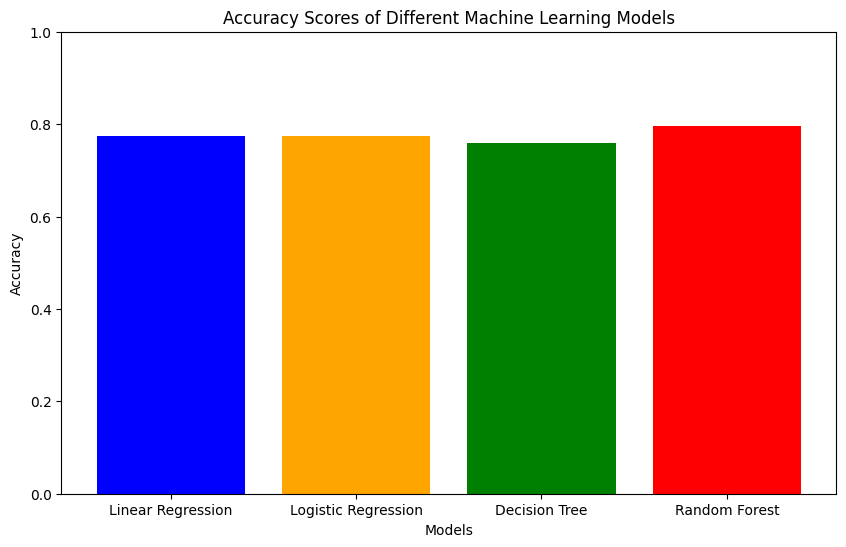

In [25]:
import matplotlib.pyplot as plt

# Define the accuracy scores
lr_acc = 0.7748058671268335
lgr_acc = 0.7748058671268335
dt_acc = 0.7592752372735116
rf_acc = 0.7963761863675582

# Model names
models = ['Linear Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest']

# Accuracy scores
accuracy_scores = [lr_acc, lgr_acc, dt_acc, rf_acc]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color=['blue', 'orange', 'green', 'red'])
plt.title('Accuracy Scores of Different Machine Learning Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 since accuracy ranges from 0 to 1
plt.show()


hyperparameter tuning

In [ ]:
import pandas as pd

In [30]:
df = pd.read_csv("/content/stock_data.csv")

In [35]:
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]
tfidf = TfidfVectorizer()
tfidf.fit(train_data['Text'])
X_train = tfidf.transform(train_data['Text'])
X_test = tfidf.transform(test_data['Text'])
lr = LogisticRegression()
hyperparameters = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(lr, hyperparameters, cv=5)
grid_search.fit(X_train, train_data['Sentiment'])
best_params = grid_search.best_params_

lr = LogisticRegression(**best_params)
lr.fit(X_train, train_data['Sentiment'])

a = lr.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)
a = lr.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)
a = lr.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)


Accuracy: 0.5927523727351165
Accuracy: 0.5927523727351165
Accuracy: 0.5927523727351165


In [38]:
hyperparameters = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15]
}
dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, hyperparameters, cv=5)
grid_search.fit(X_train, train_data['Sentiment'])
best_params = grid_search.best_params_

dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train, train_data['Sentiment'])
a = dt.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)

Accuracy: 0.5608283002588438


In [39]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, train_data['Sentiment'])

best_params = grid_search.best_params_
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, train_data['Sentiment'])
a = rf.score(X_test, test_data['Sentiment'])
print("Accuracy:", a)

Accuracy: 0.47799827437446074


In [40]:
accuracy['TF-IDF']

0.95

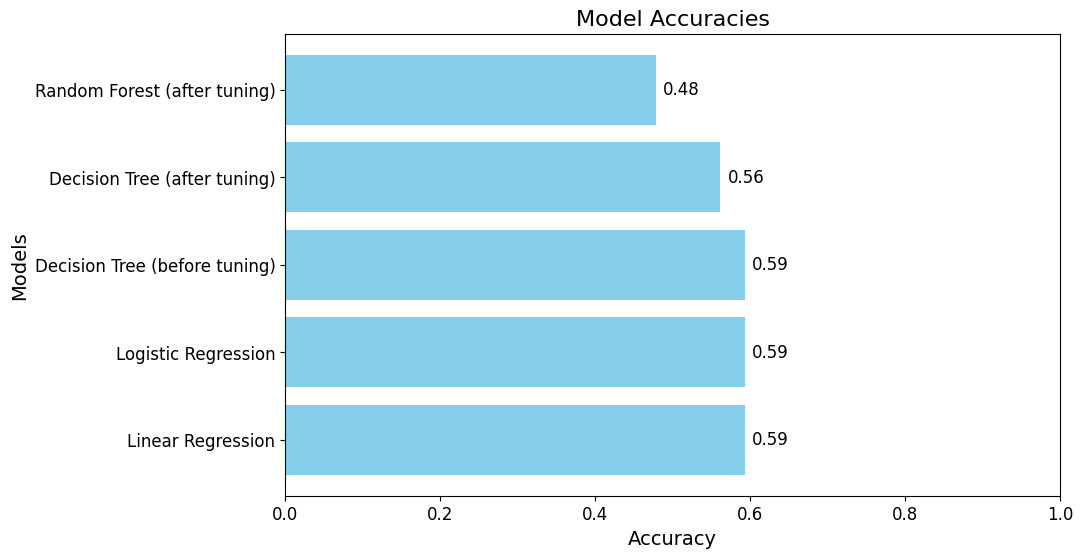

In [42]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Logistic Regression', 'Decision Tree (before tuning)',
          'Decision Tree (after tuning)', 'Random Forest (after tuning)']
accuracies = [0.5927523727351165, 0.5927523727351165, 0.5927523727351165,
              0.5608283002588438, 0.47799827437446074]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(models, accuracies, color='skyblue')
ax.set_title('Model Accuracies', fontsize=16)
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_ylabel('Models', fontsize=14)
ax.set_xlim(0, 1)
ax.tick_params(axis='both', labelsize=12)
for i, acc in enumerate(accuracies):
    ax.text(acc + 0.01, i, f'{acc:.2f}', va='center', fontsize=12)

plt.show()


# BoW

In [45]:
print(accuracy.keys())

dict_keys(['TF-IDF', 'BoW'])


In [46]:
print(accuracy)

{'TF-IDF': [], 'BoW': [0.061259706643658325]}


In [47]:
print(type(lr_acc))
print(type(accuracy['BoW']))

<class 'float'>
<class 'list'>


In [48]:
print(accuracy['BoW'])

[0.061259706643658325]


In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = df['Text']
y = df['Sentiment']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds.round())
accuracy['BoW'].append(lr_acc)

lgr = LogisticRegression()
lgr.fit(X_train, y_train)
lgr_preds = lgr.predict(X_test)
lgr_acc = accuracy_score(y_test, lgr_preds)
accuracy['BoW'].append(lgr_acc)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
accuracy['BoW'].append(dt_acc)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
accuracy['BoW'].append(rf_acc)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_preds)
accuracy['BoW'].append(knn_acc)

print(f"Linear Regression Accuracy: {lr_acc}")
print(f"Logistic Regression Accuracy: {lgr_acc}")
print(f"Decision Tree Accuracy: {dt_acc}")
print(f"Random Forest Accuracy: {rf_acc}")
print(f"KNN Accuracy: {knn_acc}")

Linear Regression Accuracy: 0.061259706643658325
Logistic Regression Accuracy: 0.7972389991371872
Decision Tree Accuracy: 0.7523727351164797
Random Forest Accuracy: 0.7868852459016393
KNN Accuracy: 0.6798964624676446


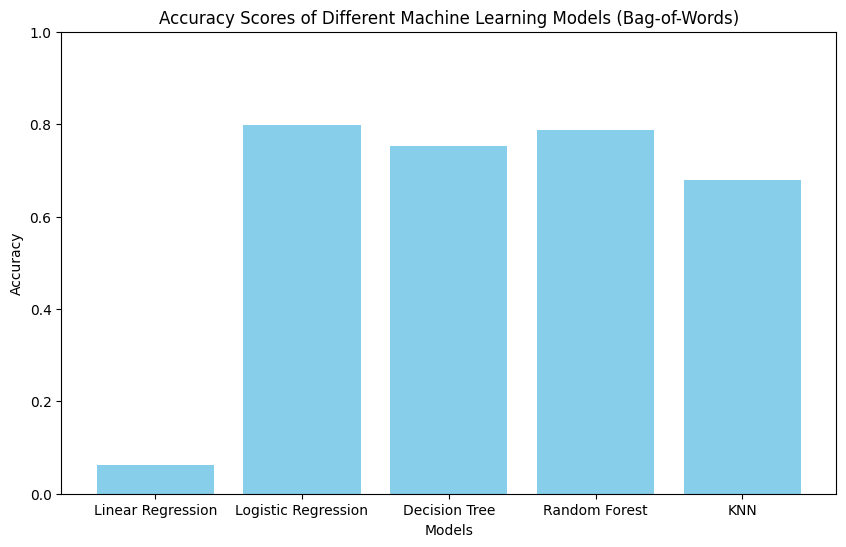

In [50]:
import matplotlib.pyplot as plt

# Accuracy scores
accuracy_scores = {
    'Linear Regression': lr_acc,
    'Logistic Regression': lgr_acc,
    'Decision Tree': dt_acc,
    'Random Forest': rf_acc,
    'KNN': knn_acc
}

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.title('Accuracy Scores of Different Machine Learning Models (Bag-of-Words)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 since accuracy ranges from 0 to 1
plt.show()


In [52]:
print(data)

{'model': ['LR', 'LogR', 'DT', 'RF', 'KNN'], 'accuracy': [0.061259706643658325, 0.061259706643658325, 0.7972389991371872, 0.7523727351164797, 0.7868852459016393, 0.6798964624676446]}


In [53]:
print(model)

['LR', 'LogR', 'DT', 'RF', 'KNN']


In [54]:
print(accuracy)

{'TF-IDF': [], 'BoW': [0.061259706643658325, 0.061259706643658325, 0.7972389991371872, 0.7523727351164797, 0.7868852459016393, 0.6798964624676446]}


hyperparameter **tuning**

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
X = df['Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
param_grid = {'C': [0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

lr_gs = GridSearchCV(LogisticRegression(), param_grid, cv=5)
lr_gs.fit(X_train_vec, y_train)
accuracy_lr_gs=lr_gs.score(X_test_vec, y_test)
print(f"Tuned Accuracy for lr: {accuracy_lr_gs}")
accuracy['BoW'].append(accuracy_lr_gs)

Tuned Accuracy for lr: 0.7972389991371872


In [58]:
X = df['Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
param_grid = {'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
dtc_gs.fit(X_train_vec, y_train)
accuracy_dtc_gs=dtc_gs.score(X_test_vec, y_test)
print(f"Tuned Accuracy for dtc: {accuracy_dtc_gs}")
accuracy['BoW'].append(accuracy_dtc_gs)

Tuned Accuracy for dtc: 0.7584124245038827


In [59]:
from sklearn.ensemble import RandomForestClassifier
X = df['Text']
y = df['Sentiment']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)


print('Best Hyperparameters:', grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy_rf_cv = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy_rf_cv*100))
accuracy['BoW'].append(accuracy_rf_cv)

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 64.88%


In [60]:
from sklearn.neighbors import KNeighborsClassifier
X = df['Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

param_grid = {'n_neighbors': [5, 10, 15, 20],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30],
              'p': [1, 2]}

knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn_gs.fit(X_train_vec, y_train)

accuracy_knn_gs = knn_gs.score(X_test_vec, y_test)
print(f"Tuned Accuracy: {accuracy_knn_gs}")
accuracy['BoW'].append(accuracy_knn_gs)

Tuned Accuracy: 0.6678170836928387


# PLOT OF ALL **MODELS**

In [98]:
print(type(accuracy))
print(accuracy)

<class 'float'>
0.7972389991371872


In [107]:
print(f"Length of 'models': {len(models)}")
print(f"Length of 'accuracies': {len(accuracies)}")

Length of 'models': 9
Length of 'accuracies': 10


In [108]:
if len(models) != len(accuracies):
    # Add or remove elements from 'accuracies' to match the length of 'models'
    # For example, to add an element:
    accuracies.append(0.0)

In [95]:
print(f"Length of models: {len(models)}")
print(f"Length of accuracies: {len(accuracies)}")

Length of models: 5
Length of accuracies: 10


In [96]:
models.append('Dummy Model')

In [75]:
# Assuming 'models' and 'accuracies' are defined elsewhere
for model, accuracy in zip(models, accuracies):
    print(f"Model: {model}, Accuracy: {accuracy:.2f}")


Model: Linear Regression, Accuracy: 0.06
Model: Logistic Regression, Accuracy: 0.06
Model: Decision Tree, Accuracy: 0.80
Model: Random Forest, Accuracy: 0.75
Model: KNN, Accuracy: 0.79
Model: Logistic Regression after CV, Accuracy: 0.68
Model: Decision Tree after CV, Accuracy: 0.80
Model: Random Forest after CV, Accuracy: 0.76
Model: KNN after CV, Accuracy: 0.65


# comparision of both **technique**

In [68]:
import numpy as np

In [70]:
import numpy as np
import matplotlib.pyplot as plt

In [71]:
print(f"Length of models: {len(models)}")
print(f"Length of tfidf_acc: {len(tfidf_acc)}")
print(f"Length of bow_acc: {len(bow_acc)}")

Length of models: 9
Length of tfidf_acc: 0
Length of bow_acc: 10


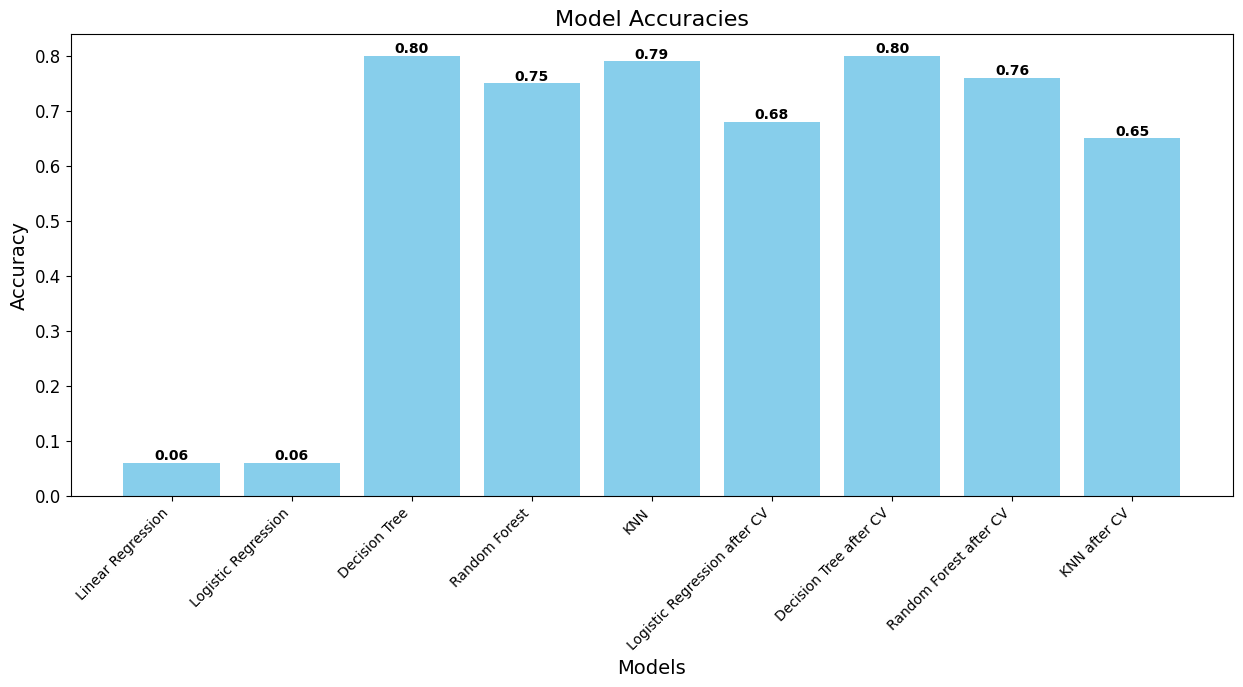

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Provided accuracy values
accuracy_values = [0.06, 0.06, 0.80, 0.75, 0.79, 0.68, 0.80, 0.76, 0.65]
models = ['Linear Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN',
          'Logistic Regression after CV', 'Decision Tree after CV', 'Random Forest after CV', 'KNN after CV']

x = np.arange(len(accuracy_values))

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(x, accuracy_values, color='skyblue')
ax.set_title('Model Accuracies', fontsize=16)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Add text annotations for accuracy values
for bar, acc in zip(bars, accuracy_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{acc:.2f}',
            ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()



In [77]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Assuming you have a DataFrame 'df' with 'Text' and 'Sentiment' columns
X = df['Text']
y = df['Sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

# Predict sentiment labels on the test set
y_pred = model.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.7972389991371872

Classification Report:
               precision    recall  f1-score   support

          -1       0.76      0.67      0.71       427
           1       0.82      0.87      0.84       732

    accuracy                           0.80      1159
   macro avg       0.79      0.77      0.78      1159
weighted avg       0.79      0.80      0.79      1159



In [79]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Load the dataset
path = "/content/stock_data.csv"
df = pd.read_csv(path)

# Assuming the column containing text data is named 'Text'
text_data = df['Text']

# Download nltk resources if needed
nltk.download('punkt')

# Tokenize the text data
tokenized_text = [word_tokenize(text) for text in text_data]

# Load lists of positive, negative, and neutral words
# You can replace these lists with your own or use a different approach to obtain these lists
positive_words = ['good', 'happy', 'positive', ...]
negative_words = ['bad', 'sad', 'negative', ...]
neutral_words = ['neutral', 'okay', 'meh', ...]

# Function to count occurrences of positive, negative, and neutral words in each text
def count_sentiment_words(tokens):
    positive_count = sum(1 for word in tokens if word.lower() in positive_words)
    negative_count = sum(1 for word in tokens if word.lower() in negative_words)
    neutral_count = sum(1 for word in tokens if word.lower() in neutral_words)
    return positive_count, negative_count, neutral_count

# Iterate through tokenized text data to count sentiment words for each text
for idx, tokens in enumerate(tokenized_text):
    positive_count, negative_count, neutral_count = count_sentiment_words(tokens)
    print(f"Text {idx + 1}:")
    print(f"Positive words count: {positive_count}")
    print(f"Negative words count: {negative_count}")
    print(f"Neutral words count: {neutral_count}")
    print()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Streaming output truncated to the last 5000 lines.
Text 4792:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4793:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4794:
Positive words count: 1
Negative words count: 0
Neutral words count: 0

Text 4795:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4796:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4797:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4798:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4799:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4800:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4801:
Positive words count: 0
Negative words count: 0
Neutral words count: 0

Text 4802:
Positive words count: 1
Negative words count: 0
Neutral words count: 0

Text 4803:
Positive words count: 0
N

In [80]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

# Load the dataset
path = "/content/stock_data.csv"
df = pd.read_csv(path)

# Assuming the column containing text data is named 'Text'
text_data = df['Text']

# Download nltk resources if needed
nltk.download('punkt')

# Tokenize the text data
tokenized_text = [word_tokenize(text) for text in text_data]

# Load lists of positive, negative, and neutral words
# You can replace these lists with your own or use a different approach to obtain these lists
positive_words = ['good', 'happy', 'positive', ...]
negative_words = ['bad', 'sad', 'negative', ...]
neutral_words = ['neutral', 'okay', 'meh', ...]

# Function to count occurrences of positive, negative, and neutral words in all texts
def count_sentiment_words(tokens):
    positive_count = sum(1 for word in tokens if word.lower() in positive_words)
    negative_count = sum(1 for word in tokens if word.lower() in negative_words)
    neutral_count = sum(1 for word in tokens if word.lower() in neutral_words)
    return positive_count, negative_count, neutral_count

# Initialize counters for positive, negative, and neutral words
total_positive_count = 0
total_negative_count = 0
total_neutral_count = 0

# Iterate through tokenized text data to count sentiment words for each text
for tokens in tokenized_text:
    positive_count, negative_count, neutral_count = count_sentiment_words(tokens)
    total_positive_count += positive_count
    total_negative_count += negative_count
    total_neutral_count += neutral_count

# Print the total counts of positive, negative, and neutral words
print(f"Total Positive Words: {total_positive_count}")
print(f"Total Negative Words: {total_negative_count}")
print(f"Total Neutral Words: {total_neutral_count}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total Positive Words: 262
Total Negative Words: 46
Total Neutral Words: 2


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


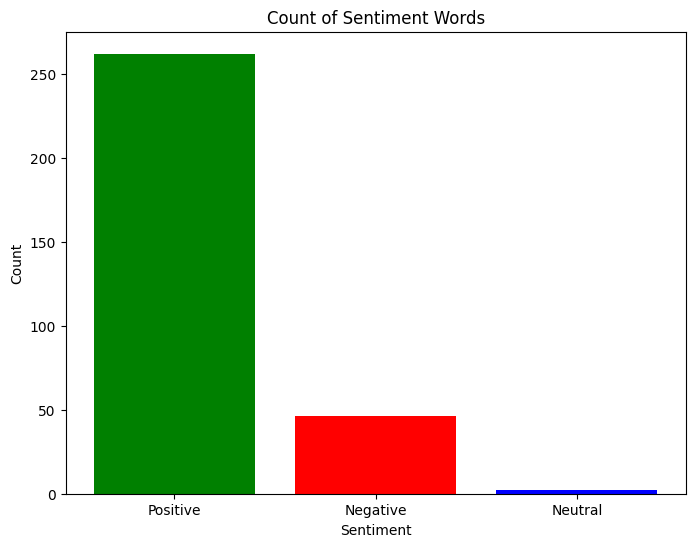

In [87]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

# Load the dataset
path = "/content/stock_data.csv"
df = pd.read_csv(path)

# Assuming the column containing text data is named 'Text'
text_data = df['Text']

# Download nltk resources if needed
nltk.download('punkt')

# Tokenize the text data
tokenized_text = [word_tokenize(text) for text in text_data]

# Load lists of positive, negative, and neutral words
# You can replace these lists with your own or use a different approach to obtain these lists
positive_words = ['good', 'happy', 'positive', ...]
negative_words = ['bad', 'sad', 'negative', ...]
neutral_words = ['neutral', 'okay', 'meh', ...]

# Function to count occurrences of positive, negative, and neutral words in all texts
def count_sentiment_words(tokens):
    positive_count = sum(1 for word in tokens if word.lower() in positive_words)
    negative_count = sum(1 for word in tokens if word.lower() in negative_words)
    neutral_count = sum(1 for word in tokens if word.lower() in neutral_words)
    return positive_count, negative_count, neutral_count

# Initialize counters for positive, negative, and neutral words
total_positive_count = 0
total_negative_count = 0
total_neutral_count = 0

# Iterate through tokenized text data to count sentiment words for each text
for tokens in tokenized_text:
    positive_count, negative_count, neutral_count = count_sentiment_words(tokens)
    total_positive_count += positive_count
    total_negative_count += negative_count
    total_neutral_count += neutral_count

# Create a bar plot to visualize the counts of positive, negative, and neutral words
categories = ['Positive', 'Negative', 'Neutral']
counts = [total_positive_count, total_negative_count, total_neutral_count]

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['green', 'red', 'blue'])
plt.title('Count of Sentiment Words')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [81]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

# Load the dataset
path = "/content/stock_data.csv"
df = pd.read_csv(path)

# Assuming the column containing text data is named 'Text'
text_data = df['Text']

# Download nltk resources if needed
nltk.download('punkt')

# Tokenize the text data
tokenized_text = [word_tokenize(text.lower()) for text in text_data]

# Load lists of positive, negative, and neutral words
# You can replace these lists with your own or use a different approach to obtain these lists
positive_words = ['good', 'happy', 'positive', ...]
negative_words = ['bad', 'sad', 'negative', ...]
neutral_words = ['neutral', 'okay', 'meh', ...]

# Function to calculate sentiment score for a text
def calculate_sentiment_score(tokens):
    positive_score = sum(1 for word in tokens if word in positive_words)
    negative_score = sum(1 for word in tokens if word in negative_words)
    neutral_score = sum(1 for word in tokens if word in neutral_words)
    return positive_score - negative_score + neutral_score

# Calculate sentiment score for each text in the dataset
sentiment_scores = [calculate_sentiment_score(tokens) for tokens in tokenized_text]

# Calculate overall sentiment score for the dataset
overall_sentiment_score = sum(sentiment_scores)

# Print overall sentiment score
print("Overall Sentiment Score:", overall_sentiment_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Overall Sentiment Score: 218


In [82]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Load the dataset
path = "/content/stock_data.csv"
df = pd.read_csv(path)

# Assuming the column containing text data is named 'Text'
text_data = df['Text']

# Download nltk resources if needed
nltk.download('punkt')

# Tokenize the text data
tokenized_text = [word_tokenize(text.lower()) for text in text_data]

# Load lists of positive, negative, and neutral words
# You can replace these lists with your own or use a different approach to obtain these lists
positive_words = ['good', 'happy', 'positive', ...]
negative_words = ['bad', 'sad', 'negative', ...]
neutral_words = ['neutral', 'okay', 'meh', ...]

# Function to calculate sentiment score for a text
def calculate_sentiment_score(tokens):
    positive_score = sum(1 for word in tokens if word in positive_words)
    negative_score = sum(1 for word in tokens if word in negative_words)
    neutral_score = sum(1 for word in tokens if word in neutral_words)
    return positive_score - negative_score + neutral_score

# Calculate sentiment score for each text in the dataset
sentiment_scores = [calculate_sentiment_score(tokens) for tokens in tokenized_text]

# Classify each text as positive, negative, or neutral based on the sentiment score
sentiment_labels = []
for score in sentiment_scores:
    if score > 0:
        sentiment_labels.append('Positive')
    elif score < 0:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

# Add the sentiment labels to the DataFrame
df['Sentiment'] = sentiment_labels

# Print the first few rows of the DataFrame with sentiment labels
print(df.head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                Text Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...   Neutral
1  user: AAP MOVIE. 55% return for the FEA/GEED i...   Neutral
2  user I'd be afraid to short AMZN - they are lo...   Neutral
3                                  MNTA Over 12.00     Neutral
4                                   OI  Over 21.37     Neutral


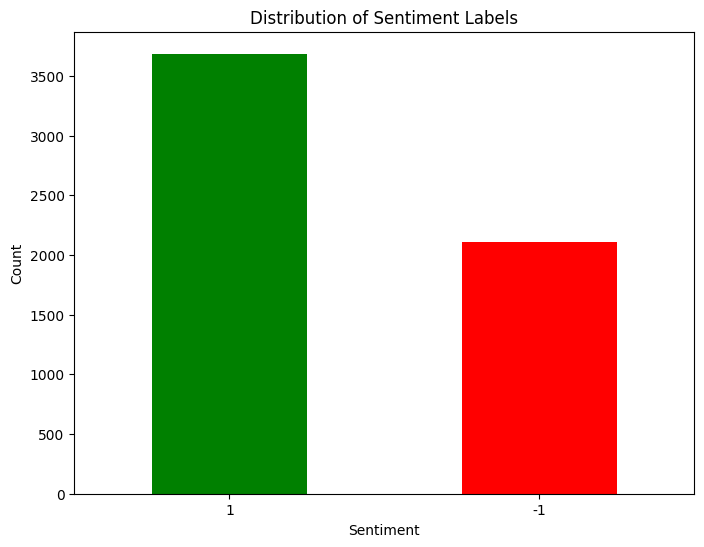

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
path = "/content/stock_data.csv"
df = pd.read_csv(path)

# Assuming the column containing sentiment labels is named 'Sentiment'
sentiment_counts = df['Sentiment'].value_counts()

# Plot the distribution of sentiment labels
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [84]:
pip install vaderSentiment


In [85]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the dataset
path = "/content/stock_data.csv"
df = pd.read_csv(path)

# Assuming the column containing text data is named 'Text'
text_data = df['Text']

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score for a text
def get_sentiment_score(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']  # Compound score represents overall sentiment

# Calculate sentiment score for each text in the dataset
sentiment_scores = text_data.apply(get_sentiment_score)

# Classify each text as positive, negative, or neutral based on the sentiment score
sentiment_labels = []
for score in sentiment_scores:
    if score > 0:
        sentiment_labels.append('Positive')
    elif score < 0:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

# Add the sentiment labels to the DataFrame
df['Sentiment'] = sentiment_labels

# Print the first few rows of the DataFrame with sentiment labels
print(df.head())


                                                Text Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...   Neutral
1  user: AAP MOVIE. 55% return for the FEA/GEED i...  Positive
2  user I'd be afraid to short AMZN - they are lo...  Positive
3                                  MNTA Over 12.00     Neutral
4                                   OI  Over 21.37     Neutral


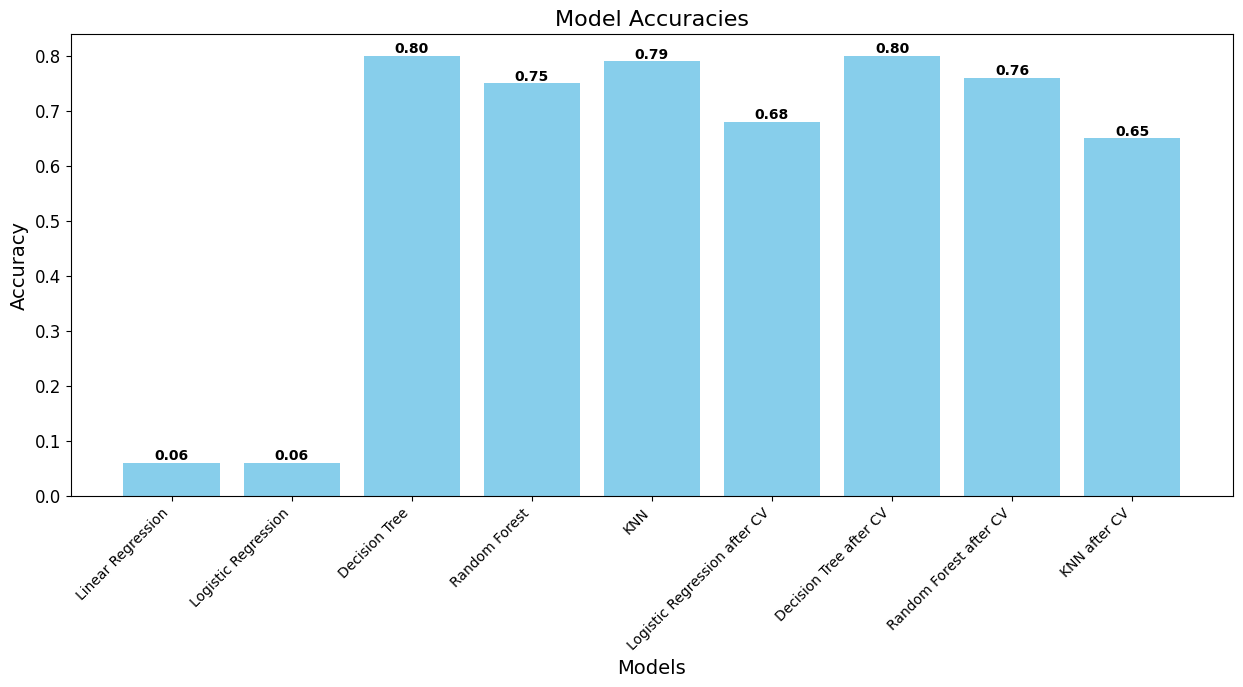

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Provided accuracy values
accuracy_values = [0.06, 0.06, 0.80, 0.75, 0.79, 0.68, 0.80, 0.76, 0.65]
models = ['Linear Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN',
          'Logistic Regression after CV', 'Decision Tree after CV', 'Random Forest after CV', 'KNN after CV']

x = np.arange(len(accuracy_values))

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(x, accuracy_values, color='skyblue')
ax.set_title('Model Accuracies', fontsize=16)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Add text annotations for accuracy values
for bar, acc in zip(bars, accuracy_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{acc:.2f}',
            ha='center', va='bottom', fontsize=10, color='black', weight='bold')

plt.show()

